# Direct Forecasting with sklearn

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we carry out **direct forecasting** to predict multiple steps into the future by using a Lasso regression and the **multi-output** functionality of scikit-learn.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)
from feature_engine.pipeline import Pipeline

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [35]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [36]:
df.tail()

,demand
date_time,
2015-02-28 19:00:00,9596.777060
2015-02-28 20:00:00,8883.230296
2015-02-28 21:00:00,8320.260550
2015-02-28 22:00:00,8110.055916
2015-02-28 23:00:00,8519.368752


## Prepare the target

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

    1 hour ahead
    2 hour ahead
    3 hour ahead

...

    24 hour ahead.

We create the target by lagging the series backwards.

In [37]:
# The forecasting horizon.
horizon = 24

# Create an empty dataframe for the targets.
y = pd.DataFrame(index=df.index)

# Add each one of the steps ahead.
for h in range(horizon):
    y[f"h_{h}"] = df.shift(periods=-h, freq="h")

In [38]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,6919.366092,7165.974188,6406.542994,5815.537828,5497.732922,5385.851060,5574.731890,5457.770634,5698.152000,5938.337614,...,6013.496578,6221.417302,6490.669762,6527.011842,6400.844422,6509.902582,6628.839522,6255.765294,6015.750184,6863.872344
2002-01-01 01:00:00,7165.974188,6406.542994,5815.537828,5497.732922,5385.851060,5574.731890,5457.770634,5698.152000,5938.337614,6104.925042,...,6221.417302,6490.669762,6527.011842,6400.844422,6509.902582,6628.839522,6255.765294,6015.750184,6863.872344,6579.219880
2002-01-01 02:00:00,6406.542994,5815.537828,5497.732922,5385.851060,5574.731890,5457.770634,5698.152000,5938.337614,6104.925042,6147.321012,...,6490.669762,6527.011842,6400.844422,6509.902582,6628.839522,6255.765294,6015.750184,6863.872344,6579.219880,6990.826420
2002-01-01 03:00:00,5815.537828,5497.732922,5385.851060,5574.731890,5457.770634,5698.152000,5938.337614,6104.925042,6147.321012,6079.707716,...,6527.011842,6400.844422,6509.902582,6628.839522,6255.765294,6015.750184,6863.872344,6579.219880,6990.826420,6382.915018
2002-01-01 04:00:00,5497.732922,5385.851060,5574.731890,5457.770634,5698.152000,5938.337614,6104.925042,6147.321012,6079.707716,6022.016562,...,6400.844422,6509.902582,6628.839522,6255.765294,6015.750184,6863.872344,6579.219880,6990.826420,6382.915018,5896.928138


In [39]:
# it will contain some nan at the end

y.tail()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
date_time,,,,,,,,,,,,,,,,,,,,,
2015-02-28 19:00:00,9596.777060,8883.230296,8320.260550,8110.055916,8519.368752,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 20:00:00,8883.230296,8320.260550,8110.055916,8519.368752,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 21:00:00,8320.260550,8110.055916,8519.368752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 22:00:00,8110.055916,8519.368752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28 23:00:00,8519.368752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Remove nan

y.dropna(inplace=True)

y.tail()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
date_time,,,,,,,,,,,,,,,,,,,,,
2015-02-27 20:00:00,9411.874558,8653.510960,8256.683092,8716.498334,8003.228986,7522.862620,7156.310422,7074.676782,7204.031944,7616.390008,...,9350.731460,9377.458878,9323.150188,9319.818104,9454.327590,9682.397648,10019.921572,10258.585392,9979.909902,9596.777060
2015-02-27 21:00:00,8653.510960,8256.683092,8716.498334,8003.228986,7522.862620,7156.310422,7074.676782,7204.031944,7616.390008,8225.845754,...,9377.458878,9323.150188,9319.818104,9454.327590,9682.397648,10019.921572,10258.585392,9979.909902,9596.777060,8883.230296
2015-02-27 22:00:00,8256.683092,8716.498334,8003.228986,7522.862620,7156.310422,7074.676782,7204.031944,7616.390008,8225.845754,8636.301286,...,9323.150188,9319.818104,9454.327590,9682.397648,10019.921572,10258.585392,9979.909902,9596.777060,8883.230296,8320.260550
2015-02-27 23:00:00,8716.498334,8003.228986,7522.862620,7156.310422,7074.676782,7204.031944,7616.390008,8225.845754,8636.301286,8910.204970,...,9319.818104,9454.327590,9682.397648,10019.921572,10258.585392,9979.909902,9596.777060,8883.230296,8320.260550,8110.055916
2015-02-28 00:00:00,8003.228986,7522.862620,7156.310422,7074.676782,7204.031944,7616.390008,8225.845754,8636.301286,8910.204970,9126.747850,...,9454.327590,9682.397648,10019.921572,10258.585392,9979.909902,9596.777060,8883.230296,8320.260550,8110.055916,8519.368752


In [41]:
# align data to available target values

df = df.loc[y.index]

df.tail()

,demand
date_time,
2015-02-27 20:00:00,9411.874558
2015-02-27 21:00:00,8653.510960
2015-02-27 22:00:00,8256.683092
2015-02-27 23:00:00,8716.498334
2015-02-28 00:00:00,8003.228986


## Split into train and test

In [42]:
# We leave 2015 in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
y_train = y.loc[:end_train]


# I need at least 6 hs prior to the start of
# forecast, to create the greatest lag feature

# sometimes you don't know which the greater lag
# will be, so you can create the test set later.

begin_test = '2014-12-31 17:59:59'
X_test  = df.loc[begin_test:]
y_test = y.loc[begin_test:]

## Set up feature engineering classes

First, we set up and test the feature engineering pipeline so we get familiar with the data transformations.

(We saw these transformers in the previous section!)

In [43]:
# Lag features.

lagf = LagFeatures(
    variables=["demand"],  # the input variables
    periods=[1, 2, 3, 4, 5, 6],  # 6 lags
    missing_values="ignore",
)

# test
lagf.fit_transform(X_train)

,demand,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6
date_time,,,,,,,
2002-01-01 00:00:00,6919.366092,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,7165.974188,6919.366092,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,6406.542994,7165.974188,6919.366092,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,5815.537828,6406.542994,7165.974188,6919.366092,NaN,NaN,NaN
2002-01-01 04:00:00,5497.732922,5815.537828,6406.542994,7165.974188,6919.366092,NaN,NaN
...,...,...,...,...,...,...,...
2014-12-31 19:00:00,7818.461408,8139.251100,8546.755882,8755.116472,8490.178162,8170.019326,8028.274856
2014-12-31 20:00:00,7801.201802,7818.461408,8139.251100,8546.755882,8755.116472,8490.178162,8170.019326
2014-12-31 21:00:00,7516.472988,7801.201802,7818.461408,8139.251100,8546.755882,8755.116472,8490.178162


In [44]:
# window features

winf = WindowFeatures(
    variables=["demand"],  # the input variables
    window=["3h", "24h"],  # average of 3 and 24 previous hours
    freq="1h",  # move 1 hr forward
    functions=["mean", "std"],
    missing_values="ignore",
    drop_original=True,    # drop demand when i don't need it any more 
)

# test
winf.fit_transform(X_train)

,demand_window_3h_mean,demand_window_3h_std,demand_window_24h_mean,demand_window_24h_std
date_time,,,,
2002-01-01 00:00:00,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,6919.366092,NaN,6919.366092,NaN
2002-01-01 02:00:00,7042.670140,174.378257,7042.670140,174.378257
2002-01-01 03:00:00,6830.627758,387.414253,6830.627758,387.414253
2002-01-01 04:00:00,6462.685003,676.966421,6576.855276,598.048293
...,...,...,...,...
2014-12-31 19:00:00,8480.374485,313.252943,7795.348068,637.761205
2014-12-31 20:00:00,8168.156130,365.006624,7783.161554,634.253353
2014-12-31 21:00:00,7919.638103,190.386120,7765.960020,627.623095


In [45]:
# Drop missing data

dropna = DropMissingData()

# test
dropna.fit_transform(winf.fit_transform(X_train))

,demand_window_3h_mean,demand_window_3h_std,demand_window_24h_mean,demand_window_24h_std
date_time,,,,
2002-01-01 02:00:00,7042.670140,174.378257,7042.670140,174.378257
2002-01-01 03:00:00,6830.627758,387.414253,6830.627758,387.414253
2002-01-01 04:00:00,6462.685003,676.966421,6576.855276,598.048293
2002-01-01 05:00:00,5906.604581,461.198224,6361.030805,707.917602
2002-01-01 06:00:00,5566.373937,222.915615,6198.500847,747.939695
...,...,...,...,...
2014-12-31 19:00:00,8480.374485,313.252943,7795.348068,637.761205
2014-12-31 20:00:00,8168.156130,365.006624,7783.161554,634.253353
2014-12-31 21:00:00,7919.638103,190.386120,7765.960020,627.623095


## Set up the model

With `MultiOutputRegressor`, we can train as many models as targets we pass. In this case, we'll train 24 models.

I set `iter` low to speed up the computations, so we may not get the best model.

In [46]:
# Lasso

lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=10))

## Set up a pipeline

**Feature-engine's pipeline** is only compatible with sklearn > 1.4.0 !!!

Feature-engine's pipeline is able to align X and y under the hood if some rows are removed. 

In our case, we introduce NA with the lags and windows, and then drop them with dropna. The pipe should align y to the resulting X.

In [47]:
# transformation pipeline - test

pipe = Pipeline(
    [
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", dropna),
    ]
).set_output(transform="pandas")

# the data that will be used for training
# or for predictions later on:

pipe.fit(X_train, y_train)

Pipeline(steps=[('lagf',
                 LagFeatures(missing_values='ignore',
                             periods=[1, 2, 3, 4, 5, 6],
                             variables=['demand'])),
                ('winf',
                 WindowFeatures(drop_original=True, freq='1h',
                                functions=['mean', 'std'],
                                missing_values='ignore', variables=['demand'],
                                window=['3h', '24h'])),
                ('dropna', DropMissingData())])

In [48]:
# transform works like sklearn, 
# it returns just the transformed 
# train set

Xt = pipe.transform(X_train)

Xt.head()

,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_window_3h_mean,demand_window_3h_std,demand_window_24h_mean,demand_window_24h_std
date_time,,,,,,,,,,
2002-01-01 06:00:00,5385.851060,5497.732922,5815.537828,6406.542994,7165.974188,6919.366092,5566.373937,222.915615,6198.500847,747.939695
2002-01-01 07:00:00,5574.731890,5385.851060,5497.732922,5815.537828,6406.542994,7165.974188,5486.105291,94.975751,6109.390996,722.331029
2002-01-01 08:00:00,5457.770634,5574.731890,5385.851060,5497.732922,5815.537828,6406.542994,5472.784528,95.331289,6027.938451,707.319452
2002-01-01 09:00:00,5698.152000,5457.770634,5574.731890,5385.851060,5497.732922,5815.537828,5576.884841,120.205144,5991.295512,670.706755
2002-01-01 10:00:00,5938.337614,5698.152000,5457.770634,5574.731890,5385.851060,5497.732922,5698.086749,240.283497,5985.999722,632.570110


In [49]:
# Good practice: transform the test and check
# that the first row corresponds to the first
# forecasting point you want in the test set

Xt = pipe.transform(X_test)

Xt.head()

,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_window_3h_mean,demand_window_3h_std,demand_window_24h_mean,demand_window_24h_std
date_time,,,,,,,,,,
2015-01-01 00:00:00,8352.992140,7571.301440,7516.472988,7801.201802,7818.461408,8139.251100,7813.588856,467.940666,7866.613480,324.746162
2015-01-01 01:00:00,7804.086240,8352.992140,7571.301440,7516.472988,7801.201802,7818.461408,7909.459940,401.357447,7857.681017,297.391852
2015-01-01 02:00:00,7174.339984,7804.086240,8352.992140,7571.301440,7516.472988,7801.201802,7777.139455,589.787948,7772.263388,366.301413
2015-01-01 03:00:00,6654.283364,7174.339984,7804.086240,8352.992140,7571.301440,7516.472988,7210.903196,575.772798,7648.043385,506.241164
2015-01-01 04:00:00,6429.598010,6654.283364,7174.339984,7804.086240,8352.992140,7571.301440,6752.740453,382.008509,7526.198848,613.404810


Note that the input features for the test, start at the desired timepoint.

We wanted to leave in the test set all data from 2015 onwards to test our model.

All previous steps were removed because they contained nan introduced by the lag features.

In [50]:
# we can also return X and y with feature-engine's pipeline

Xt, yt = pipe.transform_x_y(X_train, y_train)

In [51]:
# check the alignment of X and y

Xt.shape, X_train.shape, yt.shape, y_train.shape

((113946, 10), (113952, 1), (113946, 24), (113952, 24))

Note that the resulting input features contain less rows than the historical data. That's because `DropMissingData()` is removing them from the table of input features.

The table of input features is exactly what we want to train the model. There is no overlap of dates between train and test, and hence, no data leakage.

We can use these tables of features and target to train the model straightaway, or, as I will show later, we can add the lasso in the pipeline.

If you are not familiar with feature-engine, I suggest you leave the Lasso out of the pipeline, and use the pipeline just to generate the inputs, so you understand what the pipeline is doing and which variables you will pass to the methods fit and predict.

Now we add the model to the pipeline:

In [52]:
pipe = Pipeline(
    [
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", dropna),
        ("lasso", lasso),
    ]
)

In [53]:
# this step trains 24 lasso models

pipe.fit(X_train, y_train)

c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+10, tolerance: 3.158e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e+10, tolerance: 3.158e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\nuosv\Documents\PYTHON-PROJECTS\TRAINING_DATA_COURSES\forecasting-with-machine-learning\.venv\Lib\site-packages\sklearn\linear_mode

Pipeline(steps=[('lagf',
                 LagFeatures(missing_values='ignore',
                             periods=[1, 2, 3, 4, 5, 6],
                             variables=['demand'])),
                ('winf',
                 WindowFeatures(drop_original=True, freq='1h',
                                functions=['mean', 'std'],
                                missing_values='ignore', variables=['demand'],
                                window=['3h', '24h'])),
                ('dropna', DropMissingData()),
                ('lasso',
                 MultiOutputRegressor(estimator=Lasso(max_iter=10,
                                                      random_state=0)))])

## Forecast

We'll start by forecasting every single point of the test set.

In [54]:
# this step will produce a 24 hr forecast, starting every single hour.

forecast = pipe.predict(X_test)

forecast.shape

(1393, 24)

In [55]:
forecasts = pd.DataFrame(
    pipe.predict(X_test), 
    index=X_test.loc[end_train:].index,
    columns=[f"step_{i+1}" for i in range(24)]

)

forecasts

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,...,step_15,step_16,step_17,step_18,step_19,step_20,step_21,step_22,step_23,step_24
date_time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8535.271174,8528.403644,8379.721777,8258.024954,8207.268039,8196.131954,8219.405512,8225.109210,8266.032173,8342.129991,...,8633.071679,8702.160689,8816.958970,8863.131365,8820.461789,8559.542159,8363.933291,8317.640220,8577.002600,8983.518751
2015-01-01 01:00:00,7724.931390,7643.028908,7705.302306,7809.596085,7907.055458,8004.977997,8065.154943,8206.572700,8360.556175,8478.073579,...,8605.195064,8598.292424,8532.293090,8441.217763,8302.490931,8243.352540,8277.995355,8450.181984,8613.543315,8469.182982
2015-01-01 02:00:00,7023.751320,7017.757237,7187.971083,7314.179915,7457.310486,7587.155007,7850.152744,8247.854625,8623.919584,8959.323981,...,9098.935995,8885.685603,8626.893025,8317.965354,8162.714738,8201.564417,8326.658663,8441.733741,8151.923561,7884.795731
2015-01-01 03:00:00,6638.114360,6723.862800,6895.468467,6998.348286,7089.177727,7298.904012,7647.808103,8089.671452,8528.521443,8923.657256,...,9146.840717,8887.648076,8584.175439,8398.244427,8409.618619,8590.748152,8591.155861,8186.278510,7736.858526,7425.606155
2015-01-01 04:00:00,6516.591822,6621.895237,6784.884714,6862.818734,7005.422144,7238.820606,7505.058839,7812.018089,8107.073283,8384.505144,...,8905.004688,8799.545402,8732.582977,8765.347792,8773.608655,8822.236419,8348.176013,7848.855449,7426.000034,7274.790381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-27 20:00:00,9769.221830,9540.409884,9274.500873,9039.439275,8869.458700,8758.494761,8684.931798,8626.389504,8616.172692,8664.260759,...,9729.874398,10033.818677,10381.001012,10710.445034,10921.849761,10894.519176,10636.197450,10292.862003,10016.437325,9844.669011
2015-02-27 21:00:00,9111.141428,8851.843358,8670.904558,8562.378984,8511.596052,8504.151185,8523.744982,8616.250300,8755.792372,8920.516279,...,10129.593011,10416.293896,10686.943259,10869.034769,10879.303777,10638.876280,10293.111732,9957.582589,9661.713796,9312.907055
2015-02-27 22:00:00,8344.591336,8135.447141,8078.908090,8052.789812,8107.954628,8217.594943,8461.408181,8858.031221,9286.112591,9709.311052,...,10832.422140,10888.870067,10906.392494,10798.185541,10620.316147,10287.234089,9897.257735,9517.787132,9018.238654,8584.873645


Note that the first step in the horizon is 1 hr after the last point in the training set.

What we just did is similar to backtesting without refit. We'll cover this in section 6. The only difference between this approach and skforecast, is that here, we have a 24 hr forecast for every hour. With skforecast, we will have a 24 hr forecast every 24 hr.

What is the best way? Depends on the use case. Kishan will say more about this in **section 6**. Stay tuned!

In [56]:
# prepare for plotting the first forecast

f = forecasts.iloc[0]
f.index = X_test.loc[end_train:].head(24).index

f

date_time
2015-01-01 00:00:00    8535.271174
2015-01-01 01:00:00    8528.403644
2015-01-01 02:00:00    8379.721777
2015-01-01 03:00:00    8258.024954
2015-01-01 04:00:00    8207.268039
2015-01-01 05:00:00    8196.131954
2015-01-01 06:00:00    8219.405512
2015-01-01 07:00:00    8225.109210
2015-01-01 08:00:00    8266.032173
2015-01-01 09:00:00    8342.129991
2015-01-01 10:00:00    8422.888911
2015-01-01 11:00:00    8506.741862
2015-01-01 12:00:00    8575.568851
2015-01-01 13:00:00    8630.582490
2015-01-01 14:00:00    8633.071679
2015-01-01 15:00:00    8702.160689
2015-01-01 16:00:00    8816.958970
2015-01-01 17:00:00    8863.131365
2015-01-01 18:00:00    8820.461789
2015-01-01 19:00:00    8559.542159
2015-01-01 20:00:00    8363.933291
2015-01-01 21:00:00    8317.640220
2015-01-01 22:00:00    8577.002600
2015-01-01 23:00:00    8983.518751
Freq: h, Name: 2015-01-01 00:00:00, dtype: float64

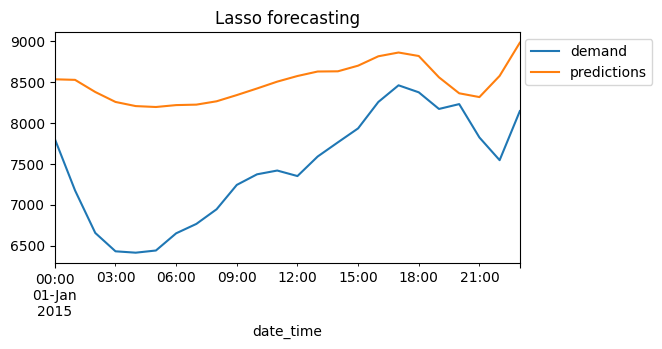

In [57]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_test.loc[end_train:].head(24).plot(ax=ax, label='train')
f.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

Let's now calculate the error over those 24 hs. That is the difference between each forecast and the actual values.

In [58]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test.loc[end_train:].head(24),
                y_pred = f
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1317183.4916197273


In [59]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test.loc[end_train:].head(24),
                y_pred = f,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1147.6861468274885


That's it! You now know how to implement direct forecasting with sklearn.

## Forecasting future data.

In the previous cells, we made a forecast, for every single hour. It's relatively striaight forward if we are forecasting with sklearn the way we show it in this notebook. We already have the features for every single time step, we just pass it through the pipeline.

The output of `pipeline.predict(X_test)` confused many students in our other course on [Feature engineering for machine learning](https://www.trainindata.com/p/feature-engineering-for-forecasting). 

So in an attempt to clarify how we'd use this model if we had it in production, let's go ahead and predict the 24hs after the end of our test set.

In [60]:
X_test.tail(3)

,demand
date_time,
2015-02-27 22:00:00,8256.683092
2015-02-27 23:00:00,8716.498334
2015-02-28 00:00:00,8003.228986


We want to forecast 24 hs of energy demand starting `2015-02-28 01:00:00`.

Note that that point is NOT in the test set. It's future, unknown data.

To use the pipeline as we set it up, we need to add the first point of the horizon as the last point in the dataframe, and include the necessary historical data.

In [61]:
# I need at least 6 hs prior to the start of
# forecast, to create the greatest lag feature

begin_test = '2015-02-27 19:00:00'  # 6 hs before first point in horizon
past_data  = df.loc[begin_test:]

# we need to add to the dataset, the first 
# point in the horizon

past_data.loc['2015-02-28 01:00:00'] = np.nan

# recast as datetime
past_data.index = pd.to_datetime(past_data.index)

past_data.shape

C:\Users\nuosv\AppData\Local\Temp\ipykernel_16936\716104246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data.loc['2015-02-28 01:00:00'] = np.nan


(7, 1)

In [62]:
past_data.head(3)

,demand
date_time,
2015-02-27 19:00:00,9980.108798
2015-02-27 20:00:00,9411.874558
2015-02-27 21:00:00,8653.510960


In [63]:
past_data.tail(3)

,demand
date_time,
2015-02-27 23:00:00,8716.498334
2015-02-28 00:00:00,8003.228986
2015-02-28 01:00:00,NaN


We have the 6 historic data points plus the point we want to forecast.

In [64]:
# And now we forecast the 24 next hours.

pipe.predict(past_data)

array([[ 7818.33635059,  7704.74372104,  7733.25795054,  7867.79929734,
         8024.10978185,  8184.06976999,  8308.59633141,  8502.0023905 ,
         8715.41307661,  8904.59374132,  9126.21441637,  9354.37238848,
         9520.41483416,  9650.7417431 ,  9805.17277966,  9985.99651806,
        10092.91408556, 10063.11074669,  9817.68560435,  9341.23433473,
         8946.66310531,  8705.36482577,  8591.3181412 ,  8292.50600082]])

This pipeline automatically returned 1 single forecasting horizon, which starts at 2015-02-28 00:00:00.

That is because the pipeline will create lags and windows, then remove all rows with NaN, which basically leaves only the last row at 2015-02-28 01:00:00, which instead of it's current value, nan, will have the lags and windows as input. And those are passed to the lasso.

If you don't believe me, the best way is to remove the lasso from the pipeline, just keep the transformers, and transform past_data to see which table of features you obtain.

In fact, why don't we do that:

In [65]:
pipe = Pipeline(
    [
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", dropna),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('lagf',
                 LagFeatures(missing_values='ignore',
                             periods=[1, 2, 3, 4, 5, 6],
                             variables=['demand'])),
                ('winf',
                 WindowFeatures(drop_original=True, freq='1h',
                                functions=['mean', 'std'],
                                missing_values='ignore', variables=['demand'],
                                window=['3h', '24h'])),
                ('dropna', DropMissingData())])

In [66]:
pipe.transform(past_data)

,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_window_3h_mean,demand_window_3h_std,demand_window_24h_mean,demand_window_24h_std
date_time,,,,,,,,,,
2015-02-28 01:00:00,8003.228986,8716.498334,8256.683092,8653.51096,9411.874558,9980.108798,8325.470137,361.575765,8836.984121,737.19864


BAAAAAMM!!!!

Nailed it.

That's all for now. I hope you found it useful!